#### TEST

In [108]:
import torch.nn as nn
import torch
from torch.nn import functional as F
from torchvision import models
import copy
import gc


# 定义训练模型, 为逻辑回归模型
# 可训练的参数数量: 7840 = 28*28*10 + 10
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out
    
# 定义MLP, 28*28-128-256-10
# 可训练的参数数量: 137074 = 28*28*128 + 128 + 128*256 + 256 + 256*10 + 10
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)
        return out


# 用来训练FashionMNIST数据集的CNN模型
# 用来训练FashionMNIST数据集的CNN模型
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)

        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, track_running_stats=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class BidirectionalLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        
        # 连接前向和后向的最后隐藏状态
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        return self.fc(hidden)
    
def ResNet10():
    return ResNet(BasicBlock, [1, 1, 1, 1])

def MobileNetV2(class_num):
    # 加载预训练的 MobileNetV2 模型
    model = models.mobilenet_v2(pretrained=True)
    # 修改最后的全连接层以输出 12 个类别
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, class_num)
    return model

def LSTM():
    # 初始化模型
    INPUT_DIM = 95811
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 4
    return BidirectionalLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [110]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim

num_classes_dict = {"MNIST": 10, "FashionMNIST": 10, "CIFAR10": 10, "ImageNet12": 12, "AgNews": 4}
global device
global test_acc_loader
global test_asr_loader


def create_rgb_trigger(pattern=None, size=9, colors=None):
    """
    创建一个size x size的RGB trigger，由3x3的彩色方块组成
    
    参数:
    pattern : 一个长度为(size/3)^2的列表，指定每个3x3块的颜色索引
               如果不指定，则随机生成
    size : 触发器的大小，默认为9
    colors : 一个包含两种RGB颜色的列表，默认为黑色和白色
    
    返回:
    trigger : size x size x 3的PIL Image对象，RGB图案
    """
    block_num = (size // 3) ** 2
    if pattern is None:
        pattern = np.random.randint(0, 2, block_num)
    elif len(pattern) != block_num:
        raise ValueError(f"Pattern must be a list of length {block_num}")
    
    if colors is None:
        colors = [(0, 0, 0), (255, 255, 255)]  # 默认黑白
    
    trigger = np.zeros((size, size, 3), dtype=np.uint8)
    
    for i in range(size // 3):
        for j in range(size // 3):
            color = colors[pattern[i * (size // 3) + j]]
            trigger[i*3:i*3+3, j*3:j*3+3] = color
    
    return Image.fromarray(trigger, mode='RGB')

class AddTrigger(object):
    def __init__(self, trigger_img):
        self.trigger_img = trigger_img

    def __call__(self, img):
        """
        将不透明的 trigger_img 添加到输入图像的右下角
        
        参数:
        img : PIL Image 对象
        
        返回:
        PIL Image 对象，右下角添加了不透明的 trigger_img
        """
        img_np = np.array(img)
        trigger_np = np.array(self.trigger_img)
        
        h, w = img_np.shape[:2]
        th, tw = trigger_np.shape[:2]
        
        # 计算 trigger 应该放置的位置
        y_offset = h - th
        x_offset = w - tw
        
        # 如果输入图像是灰度图，将其转换为 RGB
        if len(img_np.shape) == 2:
            img_np = np.stack((img_np,) * 3, axis=-1)
        
        # 直接将 trigger 覆盖到图像的右下角，不考虑透明度
        img_np[y_offset:, x_offset:, :3] = trigger_np[:, :, :3]
        
        return Image.fromarray(img_np)
    
    
# 定义预处理步骤
def get_transform(is_train=True):
    # ImageNet数据集的均值和标准差
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    if is_train:
        transform = transforms.Compose([
            transforms.Resize(256),  # 首先将图像调整为稍大的尺寸
            transforms.CenterCrop(224),  # 然后从中心裁剪出所需的224x224大小
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    return transform

# get_transform_trigger
def get_transform_add_trigger(trigger_img, is_train=True):
    # ImageNet数据集的均值和标准差
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    if is_train:
        transform = transforms.Compose([
            transforms.Resize(256),  # 首先将图像调整为稍大的尺寸
            transforms.CenterCrop(224),  # 然后从中心裁剪出所需的224x224大小
            AddTrigger(trigger_img),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    return transform

class ImagenetteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)} # class名字到class index的字典映射
        self.num_labels = len(self.classes)
        self.images = self._load_images() # 一个list,每个元素是(img_path, label)的tuple
        # 如果访问实例.images[i]返回的是一个元组(img_path, label)
        # 如果访问实例[i]返回的是一个元组(img, label)
        self.labels_array = np.array([label for _, label in self.images])

    def _load_images(self):
        images = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
    # 设置transform
    def set_transform(self, transform):
        self.transform = transform


    def random_select_delete_remain(self, proportion):
        # 从数据集中随即保留proportion比例的数据,
        import random
        random.shuffle(self.images)
        self.images = self.images[:int(len(self.images)*proportion)]
    # 打印每个类别的数量
    def get_class_num(self):
        class_num = {}
        for _, label in self.images:
            if label not in class_num:
                class_num[label] = 1
            else:
                class_num[label] += 1
        return class_num
    # split dataset into num_client parts
    def split_iid(self, num_clients):
        label_numpy = self.labels_array
        num_classes = self.num_labels
        clientid_to_each_label_indices = {i:{ j:{} for j in range(num_classes)} for i in range(num_clients)}
        for class_index in range(num_classes):
            label_index = np.where(label_numpy == class_index)[0]
            num_label = len(label_index)
            # 计算每个客户端应该分配的样本数量, 余数部分均匀分配到前面的客户端
            num_samples_per_client = num_label // num_clients
            remaining_samples = num_label % num_clients     
            # 该类别下, 每个客户端分到的样本索引
            label_index_dict = {}
            start_index = 0
            for client_index in range(num_clients):
                if client_index < remaining_samples:
                    label_index_dict[client_index] = label_index[start_index: start_index + num_samples_per_client + 1]
                    start_index += num_samples_per_client + 1
                else:
                    label_index_dict[client_index] = label_index[start_index: start_index + num_samples_per_client]
                    start_index += num_samples_per_client
            # 更新clientid_to_label_indices
            for client_index in range(num_clients):
                clientid_to_each_label_indices[client_index][class_index] = label_index_dict[client_index]
        return clientid_to_each_label_indices

    def split_image_data_dirichlet(self, num_clients, alpha):
        num_classes = self.num_labels
        clientid_to_each_label_indices = {i:{ j:{} for j in range(num_classes)} for i in range(num_clients)}
        labels_numpy = self.labels_array
        # 每个客户端至少有least_num_samples个样本
        least_num_samples = 1
        # 定义一个比例, 让每个客户端的数据数量在总体数据中的比例至少达到这个比例
        threshold_proportion = 1 / num_clients * 0.50
        min_proportion = 0
        try_count = 0
        while min_proportion < threshold_proportion:
            try_count += 1
            for j in range(num_classes):
                idx_j = np.where(labels_numpy == j)[0]
                # 确保每个客户端至少有一个样本
                initial_split = np.array_split(idx_j[:least_num_samples*num_clients], num_clients)
                remaining_indices = idx_j[least_num_samples*num_clients:]

                # 生成迪利克雷分布
                proportions = np.random.dirichlet(np.repeat(alpha, num_clients)) # 等价于np.random.dirichlet([alpha] * num_clients)
                remaining_splits = np.split(remaining_indices, (proportions * len(remaining_indices)).astype(int).cumsum()[:-1])
                for i in range(num_clients):
                    indices = np.concatenate((initial_split[i], remaining_splits[i] if i < len(remaining_splits) else []))
                    clientid_to_each_label_indices[i][j] = indices  
            # 计算每个客户端的数据比例
            min_proportion = 1
            for i in range(num_clients):
                client_proportion = 0
                for j in range(num_classes):
                    client_proportion += len(clientid_to_each_label_indices[i][j])
                client_proportion /= len(labels_numpy)
                min_proportion = min(min_proportion, client_proportion)  
        
        # 统计每个客户端的数据比例
        proportions_each_client = []
        for i in range(num_clients):
            client_proportion = 0
            for j in range(num_classes):
                client_proportion += len(clientid_to_each_label_indices[i][j])
            client_proportion /= len(labels_numpy)
            proportions_each_client.append(client_proportion)
        proportions_each_client = np.array(proportions_each_client).round(4)
        print("each client's proportion of processing data: ", proportions_each_client)
        print("each client's min threshold of data proportion : ", threshold_proportion)
        print("try_count: ", try_count)
        return clientid_to_each_label_indices
    
    # split dataset, return a set of dataset
    def split(self, num_client, iid=True, alpha=1):
        client_dataset_instances = []
        if iid:
            clientid_to_each_label_indices = self.split_iid(num_client)
        else:
            clientid_to_each_label_indices = self.split_image_data_dirichlet(num_client, alpha)
        
        for client_id in range(num_client):
            images_of_client = []
            for lable_id in clientid_to_each_label_indices[client_id]:
                for idx in clientid_to_each_label_indices[client_id][lable_id]:
                    images_of_client.append(self.images[idx])
            client_dataset_instances.append(ImagenetteDataset_per_client(client_id, images_of_client))

        return client_dataset_instances

    # 转为server端的数据集
    def to_server_dataset(self, used_for='test_acc', target_label=None):
        if used_for not in ['test_acc', 'test_asr']:
            raise ValueError("used_for must be 'test_acc' or 'test_asr'")
        if used_for == 'test_acc':
            return ImagenetteDataset_server(self.images, used_for=used_for, target_label=target_label)
        elif used_for == 'test_asr':
            if target_label == None:
                raise ValueError("target_label must be specified when used_for is 'test_asr'")
            # 去掉label == target_label的数据, 剩余数据集的label均变为target_label
            images = [(img_path, target_label) for img_path, label in self.images if label != target_label]
            return ImagenetteDataset_server(images, used_for=used_for, target_label=target_label)

class ImagenetteDataset_server(Dataset):
    # 传入 一个list images,每个元素是(image, label)的tuple
    def __init__(self, images, used_for='test_acc', target_label=None, clear_transform=None, trigger_transform=None):
        used_for_list = ['test_acc', 'test_asr']
        if used_for not in used_for_list:
            raise ValueError("used_for must be 'test_acc' or 'test_asr'")
        self.used_for = used_for # 用来决定访问__getitem__时返回的数据是否带有trigger
        self.target_label = target_label
        self.images = images
        self.clear_transform = clear_transform
        self.trigger_transform = trigger_transform
        self.num_labels = len(set([label for _, label in self.images]))
        self.labels_array = np.array([label for _, label in self.images])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.used_for == 'test_acc': 
            image = self.clear_transform(image)
        elif self.used_for == 'test_asr':
            if idx in self.trigger_img_indices:
                image = self.trigger_transform(image)
            else:
                image = self.clear_transform(image)
                label = label
        else:
            raise ValueError("used_for must be 'test_acc' or 'test_asr'")
        return image, label
    # 统计每个类别的数量
    def get_class_num(self):
        class_num = {}
        for _, label in self.images:
            if label not in class_num:
                class_num[label] = 1
            else:
                class_num[label] += 1
        return class_num
    # 设置transform
    def set_transform(self, clear_transform, trigger_transform):
        if self.used_for == 'test_acc':
            self.transform = clear_transform
        elif self.used_for == 'test_asr':
            self.transform = trigger_transform

    
class ImagenetteDataset_per_client(Dataset):
    # 传入 一个list images,每个元素是(image, label)的tuple
    def __init__(self, client_id, images, clear_transform=None, trigger_transform=None):
        self.client_id = client_id
        self.images = images
        self.clear_transform = clear_transform
        self.trigger_transform = trigger_transform
        self.num_labels = len(set([label for _, label in self.images]))
        self.labels_array = np.array([label for _, label in self.images])
        self.trigger_label_array = self.labels_array
        self.trigger_img_indices = []
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if idx in self.trigger_img_indices:
            # 需要
            image = self.trigger_transform(image)
            label = self.trigger_label_array[idx]
        else:
            image = self.clear_transform(image)
            label = label
        return image, label
    # 统计每个类别的数量
    def get_class_num(self):
        class_num = {}
        for _, label in self.images:
            if label not in class_num:
                class_num[label] = 1
            else:
                class_num[label] += 1
        return class_num
    # 注入trigger
    def set_trigger_img_indices(self, poison_data_portion, target_label):
        num_classes = self.num_labels
        labels_numpy = self.labels_array
        num_poison_samples = int(len(self.images) * poison_data_portion)
        label_to_label_indices = {i: np.where(labels_numpy == i)[0] for i in range(num_classes)}
        # 非target_label数据标签看作是优先被投毒的数据
        prior_poison_idx = np.empty((0,), dtype=int)
        for class_id in range(num_classes):
            if class_id != target_label:
                prior_poison_idx = np.concatenate((prior_poison_idx, label_to_label_indices[class_id]))
        
        # 如果非target_label的数据数量大于poison_data_portion比例的数据, 则从prior_poison_idx 随机选择poison_data_portion比例的数据
        print("prior_poison_idx: ", len(prior_poison_idx))
        print("num_poison_samples: ", num_poison_samples)
        if len(prior_poison_idx) >= int(num_poison_samples):
            poison_idx = np.random.choice(prior_poison_idx, int(num_poison_samples), replace=False)
        else:
            # 说明非target_label的数据不够, 需要从target_label中选择
            # 收集所有非target_label的数据
            poison_idx = prior_poison_idx
            # 计算需要从target_label中选择的数量
            supplement_num = num_poison_samples - len(prior_poison_idx)
            poison_idx = np.concatenate((poison_idx, label_to_label_indices[target_label][:supplement_num]))
        print("被植入trigger的样本的poison_idx: ", len(poison_idx))
        # 对poison_idx中的样本注入trigger
        self.trigger_img_indices = poison_idx
        # 同时更改trigger_label_array
        self.trigger_label_array = np.array([target_label if idx in poison_idx else label for idx, label in enumerate(self.trigger_label_array)])

    # 设置两个transform
    def set_transform(self, clear_transform, trigger_transform):
        self.clear_transform = clear_transform
        self.trigger_transform = trigger_transform

    # 获取每个类别的数量, 以及每个类别中被置入trigger的数量
    def get_class_num_with_trigger(self):
        class_num = {} # class_num[label] = number of samples
        class_num_trigger = {} # class_num_trigger[label] = number of samples with trigger
        for idx in range(len(self.images)):
            _, label = self.images[idx]
            if label not in class_num:
                class_num[label] = 1
                class_num_trigger[label] = 0
            else:
                class_num[label] += 1
            if idx in self.trigger_img_indices:
                class_num_trigger[label] += 1
        return class_num, class_num_trigger
    
# 画图, 传入多个数据集实例, 画出每个client的数据分布
def plot_data_distribution(client_dataset_instances):
    for i in range(len(client_dataset_instances)):
        class_num = client_dataset_instances[i].get_class_num()
        plt.bar(class_num.keys(), class_num.values())
        plt.title(f"Client {i}'s data distribution")
        plt.show()

# 根据clientid_to_label_indices中的index数量, 画出每个客户端的数据分布
def plot_data_distribution(client_dataset_instances):
    num_clients = len(client_dataset_instances)
    num_classes = client_dataset_instances[0].num_labels
    import matplotlib.pyplot as plt
    class_num_list = []
    for i in range(len(client_dataset_instances)):
        class_num = client_dataset_instances[i].get_class_num()
        class_num_list.append(class_num)
        print(f"Client {i}'s data distribution: ", class_num)

    plt.figure(figsize=(4, 5))
    # 每个点的坐标为(client_index, label)
    # 每个点的大小为number_of_samples
    # 每个点的颜色为client_index
    # 生成num_clients种颜色
    colors = plt.cm.jet(np.linspace(0, 1, num_clients))
    for client_index in range(num_clients):
        for label in range(num_classes):
            number_of_samples = class_num_list[client_index].get(label, 0)
            plt.scatter(client_index, label, s=number_of_samples, color=colors[client_index], alpha=0.5)
    # 坐标刻度分别是是0到num_clients-1, 0到num_classes-1
    plt.xticks(range(num_clients))
    plt.yticks(range(num_classes))
    plt.xlabel('client id')
    plt.ylabel('class')
    plt.title('Data distribution of each client')
    plt.show()

# 画出每个客户端的数据分布, 包括被注入trigger的数据, 每个客户端是一个柱状图, 所有柱状图放在一个图中
def plot_data_distribution_with_trigger(client_dataset_instances):
    # 子图数量
    num_clients = len(client_dataset_instances)
    # 计算行数和列数
    num_rows = (num_clients + 1) // 2  # 向上取整
    num_cols = 2
    # 创建子图
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    # 确保 axs 是二维数组
    axs = np.array(axs).reshape(num_rows, num_cols)

    num_clients = len(client_dataset_instances)
    num_classes = client_dataset_instances[0].num_labels
    class_num_list = []
    class_num_trigger_list = []
    for i in range(len(client_dataset_instances)):
        class_num, class_num_trigger = client_dataset_instances[i].get_class_num_with_trigger()
        class_num_list.append(class_num)
        class_num_trigger_list.append(class_num_trigger)

    for i in range(num_clients):
        row = i // 2
        col = i % 2
        class_num = class_num_list[i]
        class_num_trigger = class_num_trigger_list[i]
        axs[row, col].bar(class_num.keys(), class_num.values(),
                    color='b',
                    label='clear data')
        axs[row, col].bar(class_num_trigger.keys(), class_num_trigger.values(),
                    color='r',
                    label='trigger data')
        axs[row, col].set_title(f"Client {i}")
        axs[row, col].legend()
    plt.show()
    
# 显示样本
def display_image(img, method='normalize', title=None):
    """
    Display a PyTorch tensor as an image.
    
    Args:
    img (torch.Tensor): The input image tensor (C, H, W).
    method (str): 'normalize' or 'clip' to handle out-of-range values.
    title (str, optional): Title for the plot.
    """
    with torch.no_grad():
        if method == 'normalize':
            img_processed = (img - img.min()) / (img.max() - img.min())
        elif method == 'clip':
            img_processed = torch.clamp(img, 0, 1)
        else:
            raise ValueError("Method must be either 'normalize' or 'clip'")
        
        # Ensure the tensor is on CPU and convert to numpy array
        img_processed = img_processed.cpu().permute(1, 2, 0).numpy()
        
        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()

# 定义函数, 获取并返回每个客户端的训练集数量
def get_client_dataset_numbers(clients_images_numpuy_list, num_clients):
    number_of_samples_each_client_list = [0] * num_clients
    for i in range(num_clients):
        number_of_samples_each_client_list[i] = len(clients_images_numpuy_list[i])
    return number_of_samples_each_client_list


# 定义测试acc函数
def test_acc(global_model, test_acc_loader):
    global_model.to(device)
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_acc_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = global_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 定义测试asr函数
def test_asr(model, test_asr_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_asr_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # print('predicted: ', predicted)
            # print('labels: ', labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 加权聚合本地模型更新
def aggregate_local_model_updates_by_weight(local_model_updates, weights_of_select_clients):
    # 要求所有updates都在cpu
    assert all([all([v.device == torch.device('cpu') for v in local_model_updates[i].values()]) for i in range(len(local_model_updates))])

    print('本轮被聚合的客户端数量: ', len(local_model_updates))
    assert len(local_model_updates) == len(weights_of_select_clients)
    global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0] if "num_batches_tracked" not in k}
    for k in global_model_update:
        for i in range(len(local_model_updates)):
            global_model_update[k] += local_model_updates[i][k] * weights_of_select_clients[i]
    return global_model_update

# 平均聚合本地模型更新
def aggregate_local_updates_by_avg(local_model_updates):
    # 要求所有updates都在cpu
    assert all([all([v.device == torch.device('cpu') for v in local_model_updates[i].values()]) for i in range(len(local_model_updates))])
    
    global_model_update = {k: torch.zeros_like(local_model_updates[0][k]) for k in local_model_updates[0] if "num_batches_tracked" not in k}
    for k in global_model_update:
        for i in range(len(local_model_updates)):
            global_model_update[k] += local_model_updates[i][k]
        global_model_update[k] /= len(local_model_updates)
    return global_model_update

# 给定参数, 返回保存结果的目录
def get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method, defense_method):
    if iid == True:
        results_dir = '~/results/{}_iid-{}_numclients-{}_attack-{}_defense-{}_'.format(dataset_name, iid, num_clients, attack_method, defense_method)
    else:
        results_dir = '~/results/{}_iid-{}_alpha-{}_numclients-{}_attack-{}_defense-{}_'.format(dataset_name, iid, alpha, num_clients, attack_method, defense_method)
    # 以及一个4bytes随机的字符串, 
    # 加上年月日时分秒
    import datetime
    results_dir += datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    import uuid
    results_dir += str(uuid.uuid4())[:4] + '/'
    return results_dir

def set_GPU(gpu_id):
    if torch.cuda.is_available():
        print(f"Number of GPUs available: {torch.cuda.device_count()}")
        if gpu_id < torch.cuda.device_count():
            print(f"Using GPU: {gpu_id}")
            device = torch.device("cuda:{}".format(gpu_id))
        else:
            print(f"GPU id {gpu_id} is not available, using GPU: 0")
            device = torch.device("cuda:0")
    else:
        print("No GPU available")
        device = torch.device("cpu")
    return device

def set_random_seeds(seed_value=42, use_cuda=True):
        """
        设置所有相关随机数生成器的种子
        
        Args:
        seed_value (int): 要使用的种子值
        use_cuda (bool): 是否设置CUDA的随机种子（如果使用GPU）
        """
        # 设置 Python 内置随机模块的种子
        random.seed(seed_value)
        
        # 设置 NumPy 的随机种子
        np.random.seed(seed_value)
        
        # 设置 PyTorch 的随机种子
        torch.manual_seed(seed_value)
        
        if use_cuda and torch.cuda.is_available():
            # 设置 CUDA 的随机种子（如果使用 GPU）
            torch.cuda.manual_seed(seed_value)
            torch.cuda.manual_seed_all(seed_value)  # 如果使用多 GPU
            
            # 设置 cudnn 的随机种子
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # 设置 Python 哈希种子（影响某些 Python 对象的哈希值）
        os.environ['PYTHONHASHSEED'] = str(seed_value)

# 传入模型, 返回模型的参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 定义单个客户端的训练函数
def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model).to('cpu')
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 记录训练loss
    train_loss = 0.0

    local_model.to(device)
    # 每个客户端的训练数据
    for epoch in range(local_epochs):
        local_model.train()
        for images, labels in train_loader:
            # 检查images是否被归一化
            # print(images.max(), images.min(), images.mean(), images.std())
            local_optimizer.zero_grad()

            images, labels = images.to(device), labels.to(device)
            # 前向传播
            # print("images", images)
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            loss.backward()
            # 裁剪梯度
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1)
            local_optimizer.step()
            train_loss += loss.item()

    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    
    # if client_index == 0: 那么测试acc
    if client_index == 0 or client_index == num_clients - 1:
        local_model.eval()
        acc = test_acc(local_model, test_acc_loader)
        print('Client{} local model, Test Acc: {:.4f}'.format(client_index, acc))

    # 将模型参数转移到cpu
    local_model = local_model.to('cpu')
    # 清除 GPU 缓存
    torch.cuda.empty_cache()
    # 强制垃圾回收
    gc.collect()

    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: (local_model.state_dict()[k] - intial_model.state_dict()[k]) for k in intial_model.state_dict() if "num_batches_tracked" not in k}
    del local_model
    return local_model_update, train_loss

# 定义compriomised_clients的攻击手段 attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise', 'ALIE', 'MinMax', 'IPM', 'Backdoor']
def train_and_get_local_update_of_attack_LabelFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model).to('cpu')

    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # 记录训练loss
    train_loss = 0.0
    local_model.to(device)
    for epoch in range(local_epochs):
        local_model.train()
        for images, labels in train_loader:
            # 修改标签为 9-label, 然后训练
            labels = num_classes_dict[dataset_name] - 1 - labels
            images, labels = images.to(device), labels.to(device)
            # 前向传播
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            # 反向传播
            local_optimizer.zero_grad()
            loss.backward()
            # 裁剪梯度
            torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1)
            local_optimizer.step()
            train_loss += loss.item()

    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    
    # if client_index == 0: 那么测试acc
    if client_index == 0 or client_index == num_clients - 1:
        local_model.eval()
        acc = test_acc(local_model, test_acc_loader)
        print('Client{} local model, Test Acc: {:.4f}'.format(client_index, acc))

    # 将模型参数转移到cpu
    local_model = local_model.to('cpu')
    # 清除 GPU 缓存
    torch.cuda.empty_cache()
    # 强制垃圾回收
    gc.collect()
    
    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: (local_model.state_dict()[k] - intial_model.state_dict()[k]) for k in intial_model.state_dict() if "num_batches_tracked" not in k}
    del local_model
    return local_model_update, train_loss
        
# 定义SignFlipping的攻击函数
def train_and_get_local_update_of_attack_SignFlipping(client_index, local_model, local_optimizer, train_loader, local_epochs):
    # 记录本轮初始的模型参数
    intial_model = copy.deepcopy(local_model.state_dict())
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()

    # 记录训练loss
    train_loss = 0.0
    local_model.to(device)
    for epoch in range(local_epochs):
        local_model.train()
        # 计算完梯度都会取反
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            local_optimizer.zero_grad()
            loss.backward()
            # 裁剪梯度
            # torch.nn.utils.clip_grad_norm_(local_model.parameters(), 1)

            train_loss += loss.item()
            for param in local_model.parameters():
                param.grad.data = -param.grad.data
            local_optimizer.step()
            
    # loss
    train_loss /= len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    
    # if client_index == 0: 那么测试acc
    if client_index == 0 or client_index == num_clients - 1:
        local_model.eval()
        acc = test_acc(local_model, test_acc_loader)
        print('Client{} local model, Test Acc: {:.4f}'.format(client_index, acc))

    # 将模型参数转移到cpu
    local_model = local_model.to('cpu')
    # 清除 GPU 缓存
    torch.cuda.empty_cache()
    # 强制垃圾回收
    gc.collect()


    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: (local_model.state_dict()[k] - intial_model[k]) for k in intial_model if "num_batches_tracked" not in k}
    return local_model_update, train_loss

# 定义Noise的攻击函数
def train_and_get_local_update_of_attack_Noise(client_index, local_model):
    noise_mean=0
    noise_std=1
    # 模型更新为和模型参数同形状的正态分布
    local_model_update = {k: torch.normal(mean=noise_mean, std=noise_std, size=local_model.state_dict()[k].shape) for k in local_model.state_dict() if "num_batches_tracked" not in k}
    train_loss = 0
    return local_model_update, train_loss

# 定义IPM的攻击函数
def train_and_get_local_update_of_attack_IPM(benign_update_mean, scale):
    # 相反方向的scale倍缩放
    local_model_update = {k: -scale * benign_update_mean[k] for k in benign_update_mean if "num_batches_tracked" not in k}
    train_loss = 0
    return local_model_update, train_loss

# 定义ALIE的攻击函数
def train_and_get_local_update_of_attack_ALIE(num_clients, num_byzantine, benign_update_mean, benign_update_std):
    #  计算z_max
    s = torch.floor_divide(num_clients, 2) + 1 - num_byzantine
    cdf_value = (num_clients - num_byzantine - s) / (num_clients - num_byzantine)
    dist = torch.distributions.normal.Normal(torch.tensor(0.0), torch.tensor(1.0))
    z_max = dist.icdf(cdf_value)
    # update = mean + std * z_max
    # 对每个entry进行缩放
    local_model_update = {k: benign_update_mean[k] + benign_update_std[k] * z_max for k in benign_update_mean if "num_batches_tracked" not in k}
    train_loss = 0
    return local_model_update, train_loss

# 定义MinMax的攻击函数
def minmax_attack_by_binary_search(benign_update_mean, benign_update_std, benign_updates, benign_clients_index):
    # 所有良性梯度的mean, 标准差, 良性梯度的之间距离的最大值
    all_distances_of_benign_updates = torch.stack([l2_distance_of_2_updates(benign_updates[i], benign_updates[j]) for i in benign_clients_index for j in benign_clients_index])
    threshold = all_distances_of_benign_updates.max()

    low = 0
    high = 5
    while abs(high - low) > 0.01:
        mid = (low + high) / 2
        # mal_update = torch.stack([mean_grads - mid * deviation])
        malicious_update = {k: benign_update_mean[k] - mid * benign_update_std[k] for k in benign_update_mean if "num_batches_tracked" not in k}
        # loss = torch.cdist(mal_update, benign_updates, p=2).max()
        loss = torch.stack([l2_distance_of_2_updates(malicious_update, benign_updates[i]) for i in benign_clients_index]).max()
        if loss < threshold:
            low = mid
        else:
            high = mid
    train_loss = 0
    return malicious_update, train_loss


# 定义一个函数, 计算两个local_model_update的L2距离
def l2_distance_of_2_updates(model_update1, model_update2):
    distance = 0
    for k in model_update1:
        if "num_batches_tracked" not in k:
            distance += torch.norm(model_update1[k] - model_update2[k], p=2) ** 2
    return torch.sqrt(distance)


# 使用滑动窗口对一维向量进行采样, 返回max(abs())
def max_abs_of_sliding_window(vector, window_size):
    # 先转为绝对值
    vector = torch.abs(vector)
    # 然后用max_pool1d, ceil = True, 保证最后一个窗口不会被舍弃
    max_pool = nn.MaxPool1d(window_size, stride=window_size, ceil_mode=True)
    vector = vector.unsqueeze(0)
    vector = max_pool(vector)
    return vector.squeeze()

# 使用滑动窗口对维向量进行采样, 求出max()
def maxpool_of_sliding_window(vector, kernel_size):
    # 计算vector的长度
    length = vector.size(0)
    w = kernel_size * 2
    h = length // w

    vector = vector[:w*h]
    # reshape, 使得vector的长度是kernel_size的整数倍
    vector = vector.view(1, 1, h, w)

    y = torch.nn.functional.max_pool2d(input, kernel_size, stride=None, padding=0, dilation=1, ceil_mode=True, return_indices=False)
    # 然后将y转为1维张量
    y = y.view(-1)
    return y

# layer_wise_align: 这里将每个卷积层算出来一个max,每个矩阵算出来一个max. 返回一个vector
def layer_wise_align(vector):
    # vector是一个model_update, 里面有很多层的参数
    layers_tensor = [torch.sign(layer_tensor)*torch.max(torch.abs(layer_tensor)) for layer_tensor in [vector[k] for k in vector]]
    # 将他们拼接为一个tensor
    for i in range(len(layers_tensor)):
        # print('layers_tensor[i]: ', layers_tensor[i].shape)
        layers_tensor[i] = layers_tensor[i].flatten()
    layers_tensor = torch.cat(layers_tensor, dim=0)
    # print('layers_tensor: ', layers_tensor.shape)
    return layers_tensor    



# 传入一个模型更新, 将它转为一个向量, 并返回这个向量
def update_update_convert_to_vector(model_update):
    # print([k for k in model_update])
    return torch.cat([model_update[k].flatten() for k in model_update])

# 计算向量之间的两两欧氏距离
def compute_euclid_dis(vectors_list):
    num = len(vectors_list)
    dis_max = np.zeros((num, num))
    for i in range(num):
        for j in range(i + 1, num):
            dis_max[i, j] =torch.sqrt(torch.sum((vectors_list[i] - vectors_list[j]) ** 2))
            dis_max[j, i] = dis_max[i, j]
    return dis_max

# 距离矩阵转为投票向量
def votes_by_dismatrix(dis_matrix):
    # 获取每行前half_clients个最小距离值的索引
    half_ = dis_matrix.shape[0] // 2
    top_indices = np.argsort(dis_matrix, axis=1)[:, :half_]
    # 创建一个全零的矩阵，然后将每行的[half_clients个最小距离值的索引]位置标为1
    result_matrix = np.zeros_like(dis_matrix)
    rows, cols = np.indices(top_indices.shape)
    result_matrix[rows, top_indices] = 1
    column_sums = np.sum(result_matrix, axis=0)
    return column_sums

def extract_state_dict(model):
    """
    1. 输入模型, 提取模型的state_dict，如果存在则排除num_batches_tracked
    
    Args:
        model (torch.nn.Module): 输入的模型
    
    Returns:
        dict: 不包含num_batches_tracked的state_dict
    """
    return {name: param.clone().detach() for name, param in model.state_dict().items()
            if 'num_batches_tracked' not in name}


def synchronization_local_model(local_model, global_state_dict):
    """
    2. 使用全局模型的state_dict更新本地模型
    
    Args:
        local_model (torch.nn.Module): 本地模型
        global_state_dict (dict): 全局模型的state_dict
    """
    local_state_dict = local_model.state_dict()
    
    for name, param in global_state_dict.items():
        if name in local_state_dict:
            local_state_dict[name].copy_(param)
    
    local_model.load_state_dict(local_state_dict)

def flud_attack_by_binary_search(benign_update_mean, benign_update_std, benign_updates, benign_clients_index, num_clients, num_byzantine):
    window_size = given_size
    # benign_updates 是一个list, 里面是每个benign_client的model_update
    benign_model_digest = {}
    for i in benign_clients_index:
        benign_model_digest[i] = max_abs_of_sliding_window(update_update_convert_to_vector(benign_updates[i]), window_size)

    # 取出所有digest, 放到一个list中
    benign_digests_list = [benign_model_digest[i] for i in benign_clients_index]
    # 计算欧氏距离矩阵
    distance_matrix = compute_euclid_dis(benign_digests_list)
    
    # 给定一个距离矩阵 和 一组的距离, 返回该距离在距离矩阵中的排名, 从小到大的排名
    def get_ranks_of_distance(distances, distance_matrix):
        # distance[i] 在 distance_matrix[i]中排第几
        ranks = []
        for i in range(distance_matrix.shape[0]):
            ranks.append(np.sum(distance_matrix[i] < distances[i])+1)
        return ranks
    # 给定ranks向量, 和一个阈值, 返回向量中<=阈值的个数
    def count_less_than_or_equal_to_threshold(ranks, threshold):
        return sum([1 for rank in ranks if rank <= threshold])
    
    rank_threshold = num_clients // 2 - num_byzantine # at least the number of benign clients that mark the byzantine update as the neighbors
    low = 0
    high = 5
    while abs(high - low) > 0.01:
        mid = (low + high) / 2
        # mal_update = torch.stack([mean_grads - mid * deviation])
        malicious_update = {k: benign_update_mean[k] - mid * benign_update_std[k] for k in benign_update_mean if "num_batches_tracked" not in k}
        # 恶意update的digest
        malicious_digest = max_abs_of_sliding_window(update_update_convert_to_vector(malicious_update), window_size)
        # 计算malicious_digest到所有benign_digests的距离, 放到一个list中
        distances = [torch.norm(malicious_digest - benign_digests_list[i], p=2) for i in benign_clients_index]
        # 计算被认为是邻居的数量(distances[i]在 distance_matrix[i]中排名在threshold以内)
        ranks = get_ranks_of_distance(distances, distance_matrix)
        # 计算count
        count = count_less_than_or_equal_to_threshold(ranks, rank_threshold)
        
        if count >= rank_threshold:
            low = mid
        else:
            high = mid
    train_loss = 0
    return malicious_update, train_loss



if __name__ == "__main__":
    # 设置所有随机数
    
    
    gpu_id = 0
    set_random_seeds(seed_value=42, use_cuda=True)

    dataset_name = 'Imagenette12'
    
    num_clients = 10
    malicious_num_clients_proportion = 0.4
    malicious_clinet_indices = range(int(num_clients * malicious_num_clients_proportion))

    backdoor = True
    # 设置触发器注入比例
    backdoor_dataset_proportion = 0.5
    # 设置目标标签
    target_label = 0
    iid = True
    alpha = 10
    given_size = 4096
    half_clients = num_clients // 2
    global_learning_rate = 1
    local_learning_rate = 0.01
    local_momentum = 0.9
    local_weight_decay = 0
    num_epochs = 5
    batch_size = 32
    global_rounds = 100
    attack_method = 'Backdoor'

    # 攻击类型限制范围
    attack_methods = ['LabelFlipping', 'SignFlipping', 'Noise-(0,1)', 'ALIE', 'MinMax', 'IPM-0.1', 'IPM-100', 'Backdoor', 'NoAttack']
    assert attack_method in attack_methods, "attack_method should be one of {}".format(attack_methods)


    # 用数据集, iid, 攻击类型, 年月日时分秒, 作为存储config.json和results.json的目录
    save_reslult_dir = get_save_results_dir(dataset_name, iid, alpha, num_clients, attack_method, defense_method)
    save_reslult_dir = os.path.expanduser(save_reslult_dir)
    if not os.path.exists(save_reslult_dir):
        os.makedirs(save_reslult_dir)
    print("save_reslult_dir: ", save_reslult_dir)

    # 存储config.json
    config = {
        "defense_method": defense_method,
        "batch_size": batch_size,
        "attack_method": attack_method,
        "local_epochs": local_epochs,
        "local_learning_rate": local_learning_rate,
        "num_clients": num_clients,
        "num_classess": num_classes,
        "dataset": read_dir,
        "global_rounds": global_rounds,
        "given_size": 4096,
    }
    # 存储config.json
    import json
    with open(save_reslult_dir + 'config.json', 'w') as f:
        json.dump(config, f, indent=4)

    # 存储结果的result.json的路径
    results_json_path = save_reslult_dir + 'result.json'

    # 建立dataset_name: MNIST, FashionMNIST, CIFAR10和模型的映射
    dataset_name_to_model_map = {
        'MNIST': MLP(28*28, 128, 256, 10),
        'FashionMNIST': FashionCNN(),
        'CIFAR10': ResNet10(),
        'ImageNet12': MobileNetV2(12),
        'AgNews': LSTM()
    }



    if dataset_name == 'ImageNet12':
        all_dataset_train = ImagenetteDataset(root_dir='/scratch/wenjie/imagenet12/train', transform=None)
        all_dataset_val = ImagenetteDataset(root_dir='/scratch/wenjie/imagenet12/eval', transform=None)

        # 创建一个特定模式的trigger
        specific_pattern = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 棋盘模式
        trigger_img = create_rgb_trigger(specific_pattern, size=9)

    print("所有数据集的类别数量: ")
    print(all_dataset_train.get_class_num())
    clear_transform_client = get_transform(is_train=True)
    trigger_transform_client = get_transform_add_trigger(trigger_img, is_train=True)

    # split dataset
    client_dataset_instances = all_dataset_train.split(num_clients, iid=iid, alpha=alpha)
    
    # plot_data_distribution(client_dataset_instances)
    if backdoor:
        # 对数据进行投毒
        for i in malicious_clinet_indices:
            client_dataset_instances[i].set_trigger_img_indices(backdoor_dataset_proportion, target_label)

    for i in range(len(client_dataset_instances)):
        # 打印每个客户端的数据分布
        if attack_method == 'Backdoor':
            print(f"Client {i}'s data distribution: ", client_dataset_instances[i].get_class_num_with_trigger())
        else:
            print(f"Client {i}'s data distribution: ", client_dataset_instances[i].get_class_num())
        client_dataset_instances[i].set_transform(clear_transform_client, trigger_transform_client)

    clear_transform_server = get_transform(is_train=False)
    trigger_transform_server = get_transform_add_trigger(trigger_img, is_train=False)

    eval_acc_dataset_instance = all_dataset_val.set_transform(clear_transform_server)
    eval_asr_dataset_instance = all_dataset_val.set_transform(trigger_transform_server)

    # 根据dataset_name 对模型进行初始化
    global_model = dataset_name_to_model_map[dataset_name]
    local_models = [copy.deepcopy(global_model) for _ in range(num_clients)]

    global_model.to('cpu')
    local_models = [local_model.to('cpu') for local_model in local_models]
    
    # 并打印出global_model的结构
    print('global_model: ', global_model)
    # 打印可训练的参数数量
    print("Number of trainable parameters: ", count_parameters(global_model))

    # 定义优化器
    global_optimizer = optim.SGD(global_model.parameters(), lr = global_learning_rate)
    local_optimizers = [optim.SGD(local_models[i].parameters(), lr= local_learning_rate, momentum=local_momentum) for i in range(num_clients)]

    



NameError: name 'defense_method' is not defined

In [32]:
client_dataset_instances[0].trigger_img_indices[1]

268

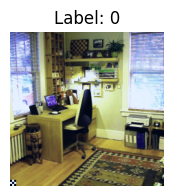

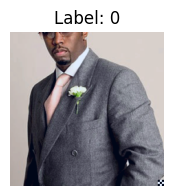

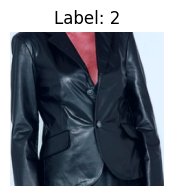

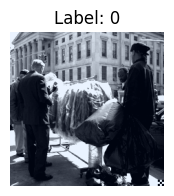

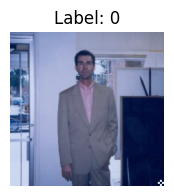

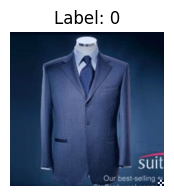

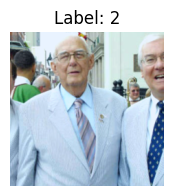

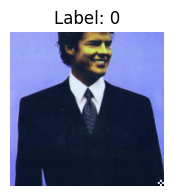

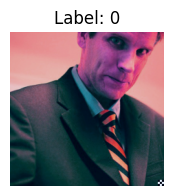

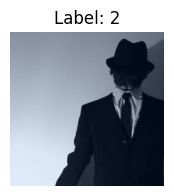

In [103]:
# 查看trigger后的样本
# id = client_dataset_instances[0].trigger_img_indices[0]

# 显示样本
def display_image(img, method='normalize', title=None):
    """
    Display a PyTorch tensor as an image.
    
    Args:
    img (torch.Tensor): The input image tensor (C, H, W).
    method (str): 'normalize' or 'clip' to handle out-of-range values.
    title (str, optional): Title for the plot.
    """
    with torch.no_grad():
        if method == 'normalize':
            img_processed = (img - img.min()) / (img.max() - img.min())
        elif method == 'clip':
            img_processed = torch.clamp(img, 0, 1)
        else:
            raise ValueError("Method must be either 'normalize' or 'clip'")
        
        # Ensure the tensor is on CPU and convert to numpy array
        img_processed = img_processed.cpu().permute(1, 2, 0).numpy()
        
        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed)
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()

id = client_dataset_instances[1].trigger_img_indices[-2]
# print(client_dataset_instances[0].trigger_img_indices)
img, label = client_dataset_instances[0][41]
for i in range(50,60):
    img, label = client_dataset_instances[0][i]
    display_image(img, title=f"Label: {label}")


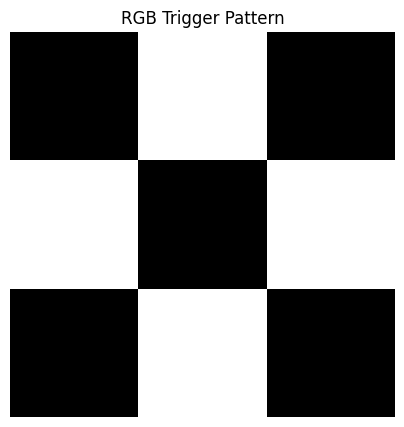

Trigger image mode: RGB
Trigger image size: (9, 9)


In [78]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def create_rgb_trigger(pattern=None, size=9, colors=None):
    """
    创建一个size x size的RGB trigger，由3x3的彩色方块组成
    
    参数:
    pattern : 一个长度为(size/3)^2的列表，指定每个3x3块的颜色索引
               如果不指定，则随机生成
    size : 触发器的大小，默认为9
    colors : 一个包含两种RGB颜色的列表，默认为黑色和白色
    
    返回:
    trigger : size x size x 3的PIL Image对象，RGB图案
    """
    block_num = (size // 3) ** 2
    if pattern is None:
        pattern = np.random.randint(0, 2, block_num)
    elif len(pattern) != block_num:
        raise ValueError(f"Pattern must be a list of length {block_num}")
    
    if colors is None:
        colors = [(0, 0, 0), (255, 255, 255)]  # 默认黑白
    
    trigger = np.zeros((size, size, 3), dtype=np.uint8)
    
    for i in range(size // 3):
        for j in range(size // 3):
            color = colors[pattern[i * (size // 3) + j]]
            trigger[i*3:i*3+3, j*3:j*3+3] = color
    
    return Image.fromarray(trigger, mode='RGB')

# 使用示例
specific_pattern = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 棋盘模式

# 创建 trigger
trigger_img = create_rgb_trigger(specific_pattern, size=9)

# 显示图像
plt.figure(figsize=(5,5))
plt.imshow(trigger_img)
plt.axis('off')
plt.title("RGB Trigger Pattern")
plt.show()

# 打印图像信息
print("Trigger image mode:", trigger_img.mode)
print("Trigger image size:", trigger_img.size)